In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np
import re
def get_data(path):
    classes = {"baby" : 0,"boy" : 1,"girl" : 2,"man" : 3,"woman" : 4}
    all_images_as_array=[]
    label=[]
    for filename in os.listdir(path):
        if re.match(r'.DS',filename):
            continue
        for imagefilename in os.listdir(path + filename):
            if re.match(r'.DS',imagefilename):
                continue
            label.append(classes[filename]);                    
            img=Image.open(path + filename + '/' + imagefilename)
            np_array = np.asarray(img)
            l,b,c = np_array.shape
            #np_array = np_array.reshape(l*b*c,)
            all_images_as_array.append(np_array)           
    return np.array(all_images_as_array), np.array(label)
path_to_train_set = 'cifar-100-data/train/'
path_to_test_set = 'cifar-100-data/test/'
X_train,y_train = get_data(path_to_train_set)
X_test, y_test = get_data(path_to_test_set)
print('X_train set shape: ',X_train.shape)
print('y_train set shape: ',y_train)
print('X_test set shape: ',X_test.shape)
print('y_test set shape: ',y_test.shape)

X_train set shape:  (2500, 32, 32, 3)
y_train set shape:  [3 3 3 ... 4 4 4]
X_test set shape:  (500, 32, 32, 3)
y_test set shape:  (500,)


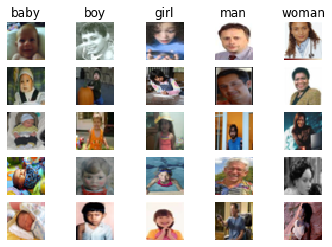

In [2]:
#Step 1.2: Visualize some examples from the dataset.
classes = ['baby', 'boy', 'girl', 'man','woman']
num_classes = len(classes)
samples_per_class = 5
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()


In [3]:
# Step 1.3: Split the data into train, val, and test sets. 
#Create a small development set as a subset of the training data

num_training = 2000
num_validation = 500
num_test = 500
num_dev = 250

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (2000, 32, 32, 3)
Train labels shape:  (2000,)
Validation data shape:  (500, 32, 32, 3)
Validation labels shape:  (500,)
Test data shape:  (500, 32, 32, 3)
Test labels shape:  (500,)


In [4]:
# Step 1.4: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (2000, 3072)
Validation data shape:  (500, 3072)
Test data shape:  (500, 3072)
dev data shape:  (250, 3072)


[126.2085 124.4515 118.7455 126.583  124.5165 118.862  126.8415 124.3785
 118.686  127.0005]


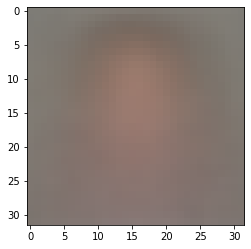

(2000, 3073) (500, 3073) (500, 3073) (250, 3073)


In [5]:
#  Step 1.5:Preprocessing: subtract the mean image

# compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# subtract the mean image from train and test data
X_train = np.subtract(X_train, mean_image, out=X_train, casting="unsafe")
#X_train -= mean_image
X_val = np.subtract(X_val, mean_image, out=X_val, casting="unsafe")
#X_val -= mean_image
X_test = np.subtract(X_test, mean_image, out=X_test, casting="unsafe")
#X_test -= mean_image
X_dev = np.subtract(X_dev, mean_image, out=X_dev, casting="unsafe")
#X_dev -= mean_image


# append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

In [6]:
###############Step-2###################
##### loss and gradients #######

# Evaluate the naive implementation of the loss we provided for you:

from classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 11.823853


iteration 0 / 1500: loss 318.125327
iteration 100 / 1500: loss 114.594841
iteration 200 / 1500: loss 43.267681
iteration 300 / 1500: loss 18.012681
iteration 400 / 1500: loss 9.200473
iteration 500 / 1500: loss 5.999703
iteration 600 / 1500: loss 4.188744
iteration 700 / 1500: loss 4.786203
iteration 800 / 1500: loss 3.523215
iteration 900 / 1500: loss 3.816479
iteration 1000 / 1500: loss 4.357524
iteration 1100 / 1500: loss 4.634345
iteration 1200 / 1500: loss 4.173833
iteration 1300 / 1500: loss 4.265357
iteration 1400 / 1500: loss 5.320938
That took 4.978453s


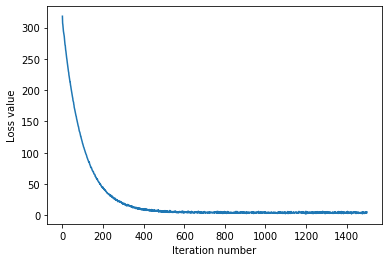

In [7]:
###############Step-3###################
##### training #######


# Classifiers.linear_classifier.py
from classifiers.linear_classifier import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [8]:
###############Step-4###################
##### predictions and evaluation #######

# LinearSVM.predict function 
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_test_pred = svm.predict(X_test)
print('validation accuracy: %f' % (np.mean(y_test == y_test_pred), ))

training accuracy: 0.263000
validation accuracy: 0.198000


In [9]:
###############Step-5##########################
#validation for hyperparameter selection ######

# accuracy is about 0.4 on the validation set.

learning_rates = [1e-8, 1e-7, 2e-7]
regularization_strengths = [2.5e4, 5e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.
 
# Choose the best hyperparameters by tunning on the validation set. For each combination of hyperparameters, train a linear SVM on the training set, compute its accuracy on the training and validation sets, and store these numbers in the result dictionary. 

# store the best validation accuracy in best_val and the SVM Object that achieves this accuracy in best_svm


# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters. 

svm = LinearSVM()

for lr in learning_rates:
    for reg in regularization_strengths:
        loss_hist = svm.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=1500)
        
        y_train_pred = svm.predict(X_train)
        acc_train = np.mean(y_train == y_train_pred)
        
        y_test_pred = svm.predict(X_test)
        acc_test = np.mean(y_test == y_test_pred)
        
        results[(lr, reg)] = (acc_train, acc_test)
        
        if acc_test > best_val:
            best_val = acc_test
            best_svm = svm
        
   
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, test_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f test accuracy: %f' % (
                lr, reg, train_accuracy, test_accuracy))
    
print('best test accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-08 reg 2.500000e+04 train accuracy: 0.319500 test accuracy: 0.240000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.441000 test accuracy: 0.252000
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.311500 test accuracy: 0.198000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.251500 test accuracy: 0.200000
lr 2.000000e-07 reg 2.500000e+04 train accuracy: 0.255500 test accuracy: 0.206000
lr 2.000000e-07 reg 5.000000e+04 train accuracy: 0.355500 test accuracy: 0.224000
best test accuracy achieved during cross-validation: 0.252000
